In [1]:
# Requests for handling HTTP get and other requests
import requests
import time # import for playing nice and not getting blocked
import pandas as pd
# from BeautifulSoup4 import BeatifulSoup if installed through pip install BeautifulSoup4
# 
from bs4 import BeautifulSoup
import plotly.express as px

In [2]:
# lets combine the above cells into a function which will always get us columns
def getColList(soup):
    column_list = ["description","url"] # we decided to that we need these two column names no matter the html
    headline = soup.find("tr", {"id":"head_line"})
    headtds = headline.find_all("td")
    headcolumns = [el.text for el in headtds[1:]] # this will get all column names starting with 2nd in HTML
    column_list += headcolumns
    return column_list

# lets make a function from the above doodle and make it work on most pages on SS
def getRowList(soup):
    trows = soup.find_all('tr')
    aprows = [row for row in trows if row.get('id',"").startswith("tr_") and not row.get('id',"").startswith("tr_bnr") ]
    return aprows

def getRow(row,colist):
    row_tds = row.find_all('td')
    rowDict = {}
    if len(row_tds) < 3: # a little sanity check
        print("Hmm bad row")
        return rowDict
    
    rowDict[colist[0]] = row_tds[2].text # so the big assumption is that we always get description in 3rd column
    rowDict[colist[1]] = "https://ss.com" + row_tds[1].find('a').get('href')
    for td,key in zip(row_tds[3:],colist[2:]): 
        rowDict[key] = td.text
    return rowDict

# so if we know how to work on single row then we can do process multiple rows
def getRows(rowlist,colist):
    return [getRow(row, colist=colist) for row in rowlist] # so return a list of dictionaries

# so with this function I can get full dataframe from a single page on ss.com not only apartments
def getDFfromURL(url):
    # print("getting data from", url)
    req = requests.get(url)
    if req.status_code != 200:
        print("Request Fail with", req.status_code)
        return None # maybe return empty dataframe here
    soup = BeautifulSoup(req.text, 'lxml')
    column_names = getColList(soup)
    rowlist = getRowList(soup)
    rows = getRows(rowlist,colist=column_names)
    return pd.DataFrame(rows, columns=column_names)

def getAllLocalUrls(url):
    """Get a list of all urls including paginated pages"""
    results = [url] # default is just the url if no extra pages found, teiksim Bolderājai...
    req = requests.get(url)
    if req.status_code != 200:
        print(f"Bad response! {req.status_code}")
        return []
    soup = BeautifulSoup(req.text, 'lxml')
    # we just need a one element
    prevanchor = soup.find('a', {"rel":"prev"}) # find finds first match only
    if prevanchor == None: # means there is only one page of ads
        return results
    href = prevanchor.attrs.get('href')
    lastPageNum = int(href.split('/page')[-1].split('.html')[0])
    print("Last page is",lastPageNum)
    nurls = [f"{url}page{n}.html" for n in range(2,lastPageNum+1)]
    results += nurls
    return results

def get_all_ads_df(start_url, save_excel_path=None):
    df_list=[] # so we will save our dataframes in a list
    local_urls = getAllLocalUrls(start_url)
    for url in local_urls:
        print(f"Gathering data from {url}")
        df_list.append(getDFfromURL(url))
        time.sleep(0.3) # we need this to play nice! to avoid rate limit or IP ban!!
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
    big_df = pd.concat(df_list) # then make a big dataframe from all the small dataframes
    if save_excel_path:
        big_df.to_excel(save_excel_path)
    return big_df

In [3]:
url = 'https://www.ss.com/lv/real-estate/flats/riga/plyavnieki/sell/'
url

'https://www.ss.com/lv/real-estate/flats/riga/plyavnieki/sell/'

In [4]:
apt = get_all_ads_df(url, save_excel_path="plavnieki_0629.xlsx")

Last page is 6
Gathering data from https://www.ss.com/lv/real-estate/flats/riga/plyavnieki/sell/
Gathering data from https://www.ss.com/lv/real-estate/flats/riga/plyavnieki/sell/page2.html
Gathering data from https://www.ss.com/lv/real-estate/flats/riga/plyavnieki/sell/page3.html
Gathering data from https://www.ss.com/lv/real-estate/flats/riga/plyavnieki/sell/page4.html
Gathering data from https://www.ss.com/lv/real-estate/flats/riga/plyavnieki/sell/page5.html
Gathering data from https://www.ss.com/lv/real-estate/flats/riga/plyavnieki/sell/page6.html


In [5]:
apt[['floor', 'floors']] = apt.Stāvs.str.split('/', expand=True)
apt.head(5)

,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena,floor,floors
0,Tiek pārdots saulains divistabu dzīvoklis klus...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Deglava 124,2,58,1/9,119.,"1,267 €","73,500 €",1,9
1,Īpašnieks pārdod 1-istabas dzīvokli ar kvalita...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Dravnieku 7,1,35,6/9,602.,"1,426 €","49,900 €",6,9
2,Владелец продаёт солнечную двухкомнатную кварт...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Dzeņu 12,2,50,3/9,602.,"1,200 €","60,000 €",3,9
3,2х комнатная квартира после капитального ремон...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Slāvu 15,2,50,1/9,602.,"1,160 €","58,000 €",1,9
4,Pārdošanai tiek piedāvāts plašs un mūsdienīgs ...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Deglava 108/6,4,84,1/9,119.,"1,143 €","96,000 €",1,9


In [ ]:
apt_floor = apt.sort_values(by='floor', ascending=False)
apt_floor.head(5)

In [ ]:
apt_floor.to_excel('apt_by_floor_jun29.xlsx')

In [6]:
apt['price'] = apt.Cena.str.split(' ').str[0]
apt.head(5)

,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena,floor,floors,price
0,Tiek pārdots saulains divistabu dzīvoklis klus...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Deglava 124,2,58,1/9,119.,"1,267 €","73,500 €",1,9,"73,500"
1,Īpašnieks pārdod 1-istabas dzīvokli ar kvalita...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Dravnieku 7,1,35,6/9,602.,"1,426 €","49,900 €",6,9,"49,900"
2,Владелец продаёт солнечную двухкомнатную кварт...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Dzeņu 12,2,50,3/9,602.,"1,200 €","60,000 €",3,9,"60,000"
3,2х комнатная квартира после капитального ремон...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Slāvu 15,2,50,1/9,602.,"1,160 €","58,000 €",1,9,"58,000"
4,Pārdošanai tiek piedāvāts plašs un mūsdienīgs ...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Deglava 108/6,4,84,1/9,119.,"1,143 €","96,000 €",1,9,"96,000"


In [7]:
apt.price = apt.price.str.replace(',','').astype('int32')
apt.head(5)

,description,url,Iela,Ist.,m2,Stāvs,Sērija,"Cena, m2",Cena,floor,floors,price
0,Tiek pārdots saulains divistabu dzīvoklis klus...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Deglava 124,2,58,1/9,119.,"1,267 €","73,500 €",1,9,73500
1,Īpašnieks pārdod 1-istabas dzīvokli ar kvalita...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Dravnieku 7,1,35,6/9,602.,"1,426 €","49,900 €",6,9,49900
2,Владелец продаёт солнечную двухкомнатную кварт...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Dzeņu 12,2,50,3/9,602.,"1,200 €","60,000 €",3,9,60000
3,2х комнатная квартира после капитального ремон...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Slāvu 15,2,50,1/9,602.,"1,160 €","58,000 €",1,9,58000
4,Pārdošanai tiek piedāvāts plašs un mūsdienīgs ...,https://ss.com/msg/lv/real-estate/flats/riga/p...,Deglava 108/6,4,84,1/9,119.,"1,143 €","96,000 €",1,9,96000


In [ ]:
apt.price.hist()

In [8]:
url_cars = 'https://www.ss.com/lv/transport/cars/ford/sell/'
url_cars

'https://www.ss.com/lv/transport/cars/ford/sell/'

In [9]:
cars = get_all_ads_df(url_cars, save_excel_path='ford_cars_jun29.xlsx')

Last page is 19
Gathering data from https://www.ss.com/lv/transport/cars/ford/sell/
Gathering data from https://www.ss.com/lv/transport/cars/ford/sell/page2.html
Gathering data from https://www.ss.com/lv/transport/cars/ford/sell/page3.html
Gathering data from https://www.ss.com/lv/transport/cars/ford/sell/page4.html
Gathering data from https://www.ss.com/lv/transport/cars/ford/sell/page5.html
Gathering data from https://www.ss.com/lv/transport/cars/ford/sell/page6.html
Gathering data from https://www.ss.com/lv/transport/cars/ford/sell/page7.html
Gathering data from https://www.ss.com/lv/transport/cars/ford/sell/page8.html
Gathering data from https://www.ss.com/lv/transport/cars/ford/sell/page9.html
Gathering data from https://www.ss.com/lv/transport/cars/ford/sell/page10.html
Gathering data from https://www.ss.com/lv/transport/cars/ford/sell/page11.html
Gathering data from https://www.ss.com/lv/transport/cars/ford/sell/page12.html
Gathering data from https://www.ss.com/lv/transport/car

In [ ]:
cars.head(5)

In [10]:
cars['price'] = cars.Cena.str.split(' ').str[0]
cars.head(5)

,description,url,Modelis,Gads,Tilp.,Nobrauk.,Cena,price
0,"Комплектация ghia, техосмотр есть, 1, 6 бензин...",https://ss.com/msg/lv/transport/cars/ford/focu...,Focus,2006,1.6,293 tūkst.,"1,300 €","1,300"
1,Pardod ford focus. 2007.gada\r\nPardodas bez n...,https://ss.com/msg/lv/transport/cars/ford/focu...,Focus,2007,1.6,249 tūkst.,"1,700 €","1,700"
2,"Tikko no Vācijas, Latvijā nav ekspluatēta, par...",https://ss.com/msg/lv/transport/cars/ford/fies...,Fiesta,2010,1.6D,135 tūkst.,"4,850 €","4,850"
3,Identisku otru Fordu atdodu līdzi kā donoru.,https://ss.com/msg/lv/transport/cars/ford/mond...,Mondeo,2000,1.8D,329 tūkst.,500 €,500
4,Недавно из Германии. \r\nВодитель и пассажир 1...,https://ss.com/msg/lv/transport/cars/ford/ka/d...,KA,2011,1.2,150 tūkst.,"3,450 €","3,450"


In [11]:
cars.price = cars.price.str.replace(',','').astype('int32')
cars.head(5)

,description,url,Modelis,Gads,Tilp.,Nobrauk.,Cena,price
0,"Комплектация ghia, техосмотр есть, 1, 6 бензин...",https://ss.com/msg/lv/transport/cars/ford/focu...,Focus,2006,1.6,293 tūkst.,"1,300 €",1300
1,Pardod ford focus. 2007.gada\r\nPardodas bez n...,https://ss.com/msg/lv/transport/cars/ford/focu...,Focus,2007,1.6,249 tūkst.,"1,700 €",1700
2,"Tikko no Vācijas, Latvijā nav ekspluatēta, par...",https://ss.com/msg/lv/transport/cars/ford/fies...,Fiesta,2010,1.6D,135 tūkst.,"4,850 €",4850
3,Identisku otru Fordu atdodu līdzi kā donoru.,https://ss.com/msg/lv/transport/cars/ford/mond...,Mondeo,2000,1.8D,329 tūkst.,500 €,500
4,Недавно из Германии. \r\nВодитель и пассажир 1...,https://ss.com/msg/lv/transport/cars/ford/ka/d...,KA,2011,1.2,150 tūkst.,"3,450 €",3450


<AxesSubplot:>

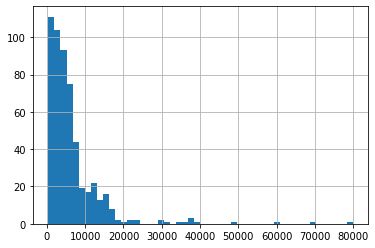

In [13]:
cars.price.hist(bins=50)

In [14]:
cars_years = cars.groupby(by='Gads')['price'].agg(["count", "min", "max", "mean"])
cars_years

,count,min,max,mean
Gads,,,,
1980,1,1888,1888,1888.000000
1983,1,1450,1450,1450.000000
1986,1,1000,1000,1000.000000
1987,2,2100,3600,2850.000000
1990,2,1990,3500,2745.000000
1991,1,2050,2050,2050.000000
1993,2,700,3000,1850.000000
1995,4,450,13100,4612.500000
1996,1,4690,4690,4690.000000


array([[<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'min'}>],
       [<AxesSubplot:title={'center':'max'}>,
        <AxesSubplot:title={'center':'mean'}>]], dtype=object)

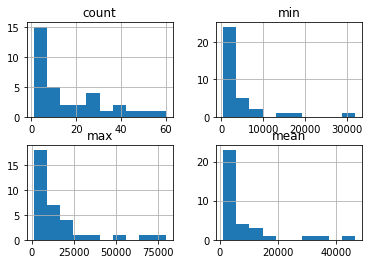

In [15]:
cars_years.hist()

In [16]:
ford_models_grouped = cars.groupby(by=['Modelis','Gads'])['price'].agg(["count", "min", "max", "mean"])

In [17]:
ford_models_grouped

count    min    max     mean
Modelis Gads                              
B-Max   2013      2   4950   5800   5375.0
        2014      1   5990   5990   5990.0
Bronco  1987      1   2100   2100   2100.0
C-Max   2003      1   1450   1450   1450.0
        2004      4    590   1450   1122.5
...             ...    ...    ...      ...
Transit 2016      5  11999  16000  13987.8
        2017      1  12500  12500  12500.0
        2018      2   8000  16940  12470.0
        2020      1  16940  16940  16940.0
        2021      1  33910  33910  33910.0

[192 rows x 4 columns]